In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# Load in title basics information
basics = pd.read_csv("data/title.basics.tsv.gz", sep="\t", na_values="\\N", compression="gzip")

# Filter titles to just movies
movies = basics[basics["titleType"] == "movie"].copy()
movies = movies[["tconst", "isAdult", "genres", "startYear"]]

/tmp/ipykernel_25725/3516675702.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv("data/title.basics.tsv.gz", sep="\t", na_values="\\N", compression="gzip")


In [9]:
# Load in ratings data
ratings = pd.read_csv("data/title.ratings.tsv.gz", sep="\t", na_values="\\N", compression="gzip")

# Merge with title data
df = movies.merge(ratings, on="tconst", how="inner")

In [10]:
actor_counts = {}

for chunk in pd.read_csv(
    "data/title.principals.tsv.gz",
    sep="\t",
    na_values="\\N",
    compression="gzip",
    chunksize=500_000,
    usecols=["tconst", "nconst", "category"]
):
    chunk = chunk[chunk["category"].isin({"actor", "actress"})]

    for nconst, count in chunk["nconst"].value_counts().items():
        actor_counts[nconst] = actor_counts.get(nconst, 0) + count 

actor_popularity = pd.Series(actor_counts, name="actor_popularity").reset_index()
actor_popularity.rename(columns={"index": "nconst"}, inplace=True)

In [11]:
movie_set = set(df["tconst"])

movie_actor_sum = {}

for chunk in pd.read_csv(
    "data/title.principals.tsv.gz",
    sep="\t",
    na_values="\\N",
    compression="gzip",
    chunksize=500_000,
    usecols=["tconst", "nconst", "category"]
):
    chunk = chunk[chunk["category"].isin({"actor", "actress"})]
    chunk = chunk[chunk["tconst"].isin(movie_set)]

    chunk = chunk.merge(actor_popularity, on="nconst", how="left")

    for t, s in chunk.groupby("tconst")["actor_popularity"].sum().items():
        movie_actor_sum[t] = movie_actor_sum.get(t, 0) + s

movie_actor_pop = pd.DataFrame({
    "tconst": list(movie_actor_sum.keys()),
    "actor_popularity": list(movie_actor_sum.values())
})

In [12]:
df = df.merge(movie_actor_pop, on="tconst", how="left")

In [15]:
# Load in crew data to compute director popularity/momentum
crew = pd.read_csv("data/title.crew.tsv.gz", sep="\t", na_values="\\N", compression="gzip")

crew = crew[crew["tconst"].isin(df["tconst"])]

crew["directors"] = crew["directors"].fillna("")
crew = crew.assign(director=crew["directors"].str.split(",")).explode("director")
crew = crew[crew["director"] != ""]

crew["director_popularity"] = crew.groupby("director")["tconst"].transform("count")

tmp = crew.merge(df[["tconst", "averageRating", "startYear"]], on="tconst", how="left")

tmp = tmp.sort_values(["director", "startYear"])

tmp["director_momentum"] = (
    tmp.groupby("director")["averageRating"].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
)

momentum = tmp.groupby("tconst")["director_momentum"].mean().reset_index()
dirpop = tmp.groupby("tconst")["director_popularity"].mean().reset_index()

df = df.merge(momentum, on="tconst", how="left")
df = df.merge(dirpop, on="tconst", how="left")

In [16]:
# One-hot encode genres
df["genres"] = df["genres"].fillna("")
genre_dummies = df["genres"].str.get_dummies(sep=",")

df = pd.concat([df, genre_dummies], axis=1)
df.drop(columns=["genres"], inplace=True)

In [17]:
# Clean by removing missing ratings
df = df.dropna(subset=["averageRating"])

for col in ["actor_popularity", "director_popularity", "director_momentum", "isAdult", "startYear", "numVotes"]:
    df[col] = df[col].fillna(0)

In [19]:
# Build feature matrix and train XGBoost regressor
y = df["averageRating"]
X = df.drop(columns=["tconst", "averageRating"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
# Evaluate XGBoost model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 1.1899087856034718
MAE: 0.8201370166163966
R^2: 0.3763412002246026


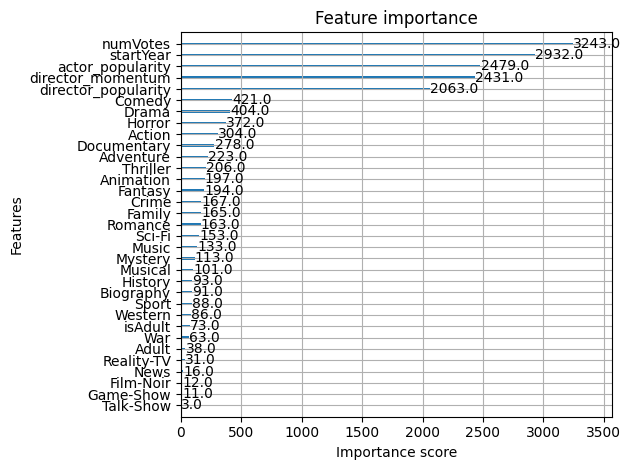

In [23]:
# Visualize feature importance
xgb.plot_importance(model)
plt.tight_layout()
plt.show()